## Задача 1.3

[Задана выборка пар изображений](https://drive.google.com/file/d/156K2MIDP3UqRc5qkH0VpI9IXhWTA-o6G/view?usp=sharing): каждая пара состоит из оригинального (original_id.bmp) изображения и искаженного (modified_id_phrase.bmp).
Также задана пара контрольных изображений original_test, modified_test.

В 99% случаев искажение заключается в добавлении белого шума. В 1% случаев искажение заключается в добавлении к изображению скрытого сообщения. 
Алгоритм заключается в следующем:
1. У исходной фразы берутся порядковые номера всех символов в порядке английского алфавита (abcz -> 0,1,2,25).
2. Полученный вектор домножается на неизвестный коэффициент alpha и складывается с вектором картинки (image = image.flatten() + alpha*v + шум).
3. Если фраза слишком короткая, искажение продолжается периодически.

Требуется раскодировать фразу из контрольной пары.

NB: предполагается, что вы найдете искаженные изображения без шума с применением статистических моделей, а не перебором.


### Ссылки
* https://imageio.readthedocs.io/en/stable/userapi.html
* https://docs.python.org/3/library/functions.html#ord

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pylab as plt
import seaborn as sns

import matplotlib.image as mpimg

from statsmodels.graphics.tsaplots import plot_acf

plt.rcParams['figure.figsize'] = (12,8)

Напишем функцию для загрузки изображений из папки, сразу преобразуем фразы, при помощи которых кодируются изображения, в последовательность чисел:

In [3]:
import imageio
import os

def load_images_from_folder(folder):
    dataset = {}
    for filename in os.listdir(folder):     
        img = mpimg.imread(os.path.join(folder,filename))
        if img is not None:
            name_parts = filename.split("_")
            name_parts[-1] = name_parts[-1].split(".")[0]
            dataset.setdefault(name_parts[1], {})
            if name_parts[0] == "modified":
                dataset[name_parts[1]]['modified']=img.flatten().astype('int16')
                dataset[name_parts[1]]['phrase'] = name_parts[2]
                dataset[name_parts[1]]['code'] = list(map(lambda x: ord(x) - 97, name_parts[2]))
            else:
                dataset[name_parts[1]]['original']=img.flatten().astype('int16')
    return dataset

Из условия задачи ясно, что нас в целом не интересуют сами векторы картинок - искажение от него никак не зависит, поэтому сразу перейдем к разнице между искаженным вектором и оригинальным, и будем её исследовать:

In [4]:
dataset = load_images_from_folder("images_full/images")
keys = list(dataset.keys())
for key in keys:
    dataset[key]['residual'] = dataset[key]['modified'] - dataset[key]['original']

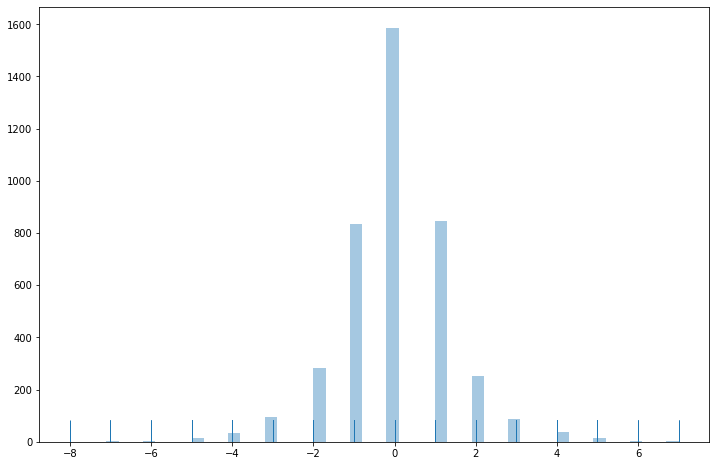

In [5]:
sns.distplot(dataset[keys[0]]['residual'], kde=False, rug=True)
plt.show()

Как мы видим, шум у нас вероятнее всего представляет нормальное распределение с нулевым матожиданием и не очень большой дисперсией(по крайней мере на этом отдельно взятом примере).

### Подход

Теперь надо разобраться с подходом, при помощи которого будем отфильтровать интересные нам для анализа изображения от просто зашумленных.
<br> 
Из постановки задачи сходу неясно, какой конкретно вид шума используется, меняются ли его параметры от сэмпла к сэмплу, нулевое ли у него матожидание, etc. Однако предположим, что матожидание у него все-таки нулевое (фраза "белый шум" на это намекает). Разумно, хоть и не очень статистически обоснованно, выглядит идея посмотреть распределение следующей статистики на нашем датасете:
$$T = \frac{\sum_{i=1}^{N}X_i}{N}$$
Очевидно, что при сделанном нами предположении о виде шума в датасете, значения этой статистики на зашумленных сэмплах должны быть близки к нулю(т.к. среднее выборки является несмещенной оптимальной оценкой матожидания).

In [6]:
dataset[keys[0]]['residual'].mean()

-0.015869140625

Про закодированные сэмплы мы могли бы просто сказать, что матожидание должно быть строго больше нуля, и это было бы правдой, не будь наши числа значениями пикселей. Эта особенность задачи включает в себя в частности определенную особенность сложения векторов - если сумма исходного значения и искажения превосходит 255, результат может оказаться меньше исходного значения, что означает, что мы не можем с уверенностью делать заявлений насчет матожидания.
<br>
Было бы разумно проверить, принадлежит ли выборка нормальному распределению (искаженные значения принадлежали бы ему, только если все буквы в кодовой фразе были одинаковыми, что не очень интересно для нас - иначе она принадлежит дискретному распределению, зависящему от кодовой фразы), хотя даже тут все приходится делать из предположения, что этого "переполнения" не происходит. Впрочем, вот что происходит при попытке применить стандартного Шапиро-Уилка к, казалось бы, похожему на нормальный шуму:

In [7]:
st.shapiro(dataset[keys[0]]['residual'])

(0.9212901592254639, 6.172719735350819e-42)

Значения очень удручающие - мы не можем использовать такой тест для определения искаженных данных, на них этот тест покажет еще меньшие значения. QQ-Plot, кстати, оправдывает этот результат:

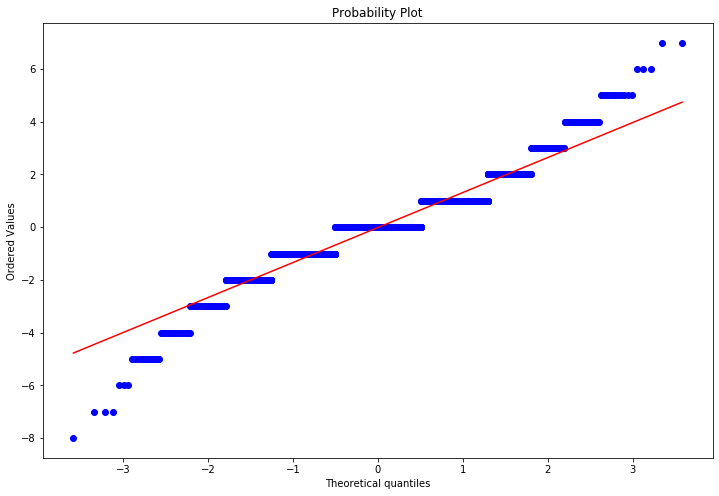

In [8]:
_ = st.probplot(dataset[keys[0]]['residual'], plot=plt)

Так что, было решено для фильтрации попробовать применить предложенную выше инновационную статистику, надеясь, что все предположения (малое влияние "переполнения" на результаты, равенство матожидания шума нулю) выполнены. Результаты превзошли все ожидания:

In [9]:
means = []
for key in keys:
    residuals = dataset[key]['residual']
    e = residuals.mean()
    means.append((e, key))

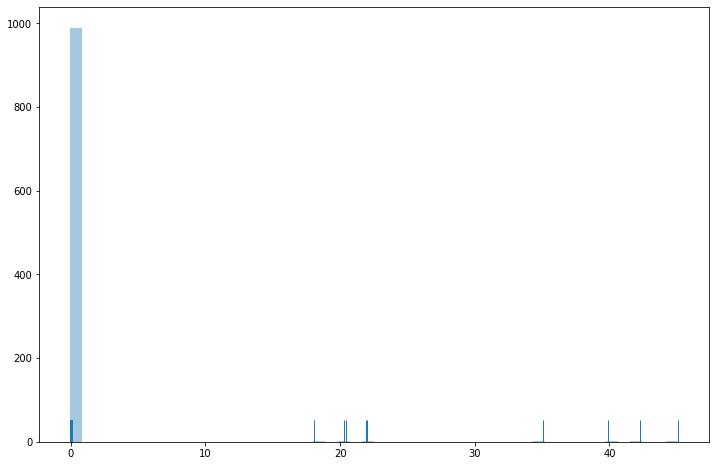

In [10]:
sns.distplot([x[0] for x in means], kde=False, rug=True)
plt.show()

In [11]:
filtered_keys = [x[1] for x in filter(lambda x: x[0]>1, means)]
print(len(filtered_keys))

10


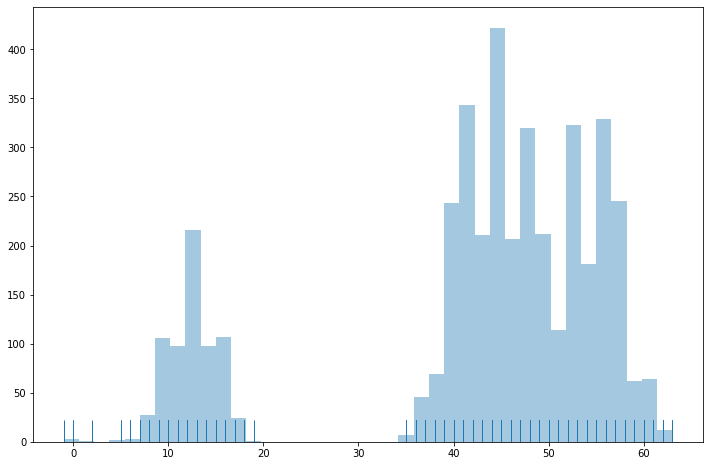

In [12]:
sample = dataset[filtered_keys[0]]
sns.distplot(sample['residual'], kde=False, rug=True)
plt.show()

Как мы видим, распределение разительно отличается от предполагаемого шумового вектора, также можно заметить, что количество предполагаемых искаженных картинок в точности равно 1% от 1000 картинок, как и говорилось в условии, что не может не обнадеживать.

### Определение коэффициента $\alpha$

Поскольку искажение продолжается периодично, рассмотрим вектор изображения как time-series и выделим сезональную составляющую:

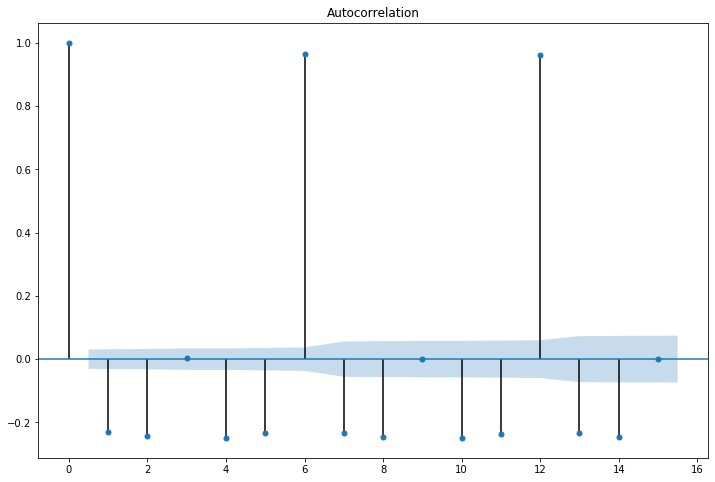

In [13]:
plot_acf(sample['residual'], lags=15)
plt.show()

По графику сразу можно предположить, какая длина у периодичной составляющей вектора, т.е. длина кодовой фразы - и что самое главное, она совпадает с настоящей.

Можно было бы попытаться учесть вероятностную модель округления чисел при умножении их на произвольный коэффциент, однако это выглядит сложным, поэтому, опять же, предположим, что вид шума был везде одинаков, следовательно выборки однородные и просто соберем все вместе, обучив на этом линейную регрессию(предварительно корректно сопоставив каждому значению вектора коэффициент, соответствующий коду):

In [14]:
from sklearn.linear_model import LinearRegression
from itertools import cycle

linreg = LinearRegression()

In [15]:
X_whole = []
y_whole = []
for key in filtered_keys:
    X = dataset[key]['residual']
    repeated_code_generator = cycle(dataset[key]['code'])
    y = [next(repeated_code_generator) for y in range(len(X))]
    X_whole.extend(X)
    y_whole.extend(y)
X_whole = np.array(X_whole).reshape(-1,1)
y_whole = np.array(y_whole).reshape(-1,1)

In [16]:
linreg = LinearRegression()
linreg.fit(X_whole, y_whole)
linreg.coef_

array([[0.31273446]])

Теперь попробуем применить это сакральное знание для расшифровки секретной фразы:

In [18]:
test_folder = "images_full"
modified_test = mpimg.imread(os.path.join(test_folder, "modified_test.bmp")).flatten().astype('int16')
original_test = mpimg.imread(os.path.join(test_folder, "original_test.bmp")).flatten().astype('int16')
residuals_test = modified_test - original_test

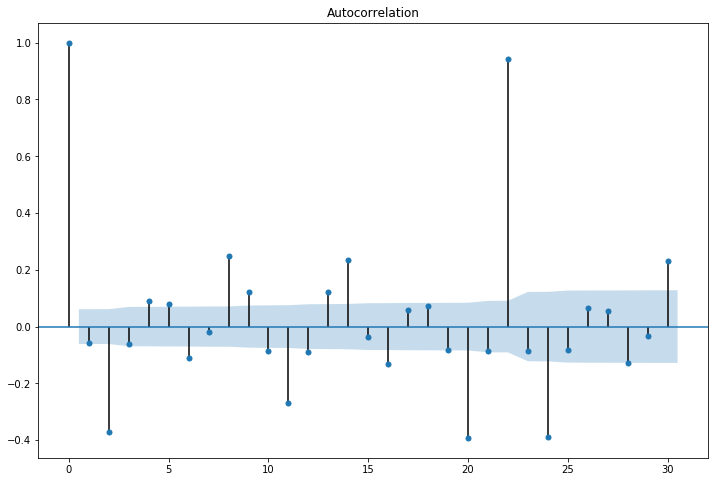

In [19]:
plot_acf(residuals_test, lags=30)
plt.show()

По ACF можно заключить, что наша кодовая фраза длиной 22 символа.

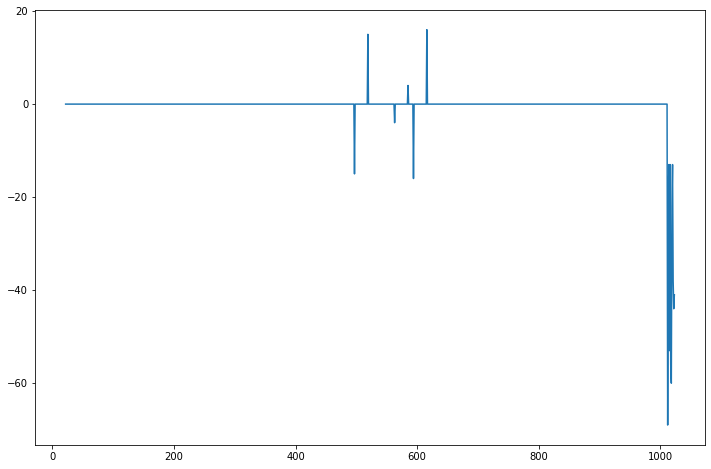

In [20]:
plt.plot(pd.Series(residuals_test).diff(22)[22:])
plt.show()

График выглядит слегка странно, но выглядит все так, будто мы на верном пути.

Теперь предскажем значения для первых 22 значений вектора (как оказалось, шума у нас в тесте нет):

In [21]:
predictions = linreg.predict(residuals_test[:22].reshape(-1, 1))

In [22]:
''.join([chr(int(round(x+97))) for x in predictions.flatten()])

'wheresthemoneylebowski'

Как мы видим, план по применению выборочного среднего в качестве статистики оказался надежным, как швейцарские часы. Теперь можно поехать в боулинг поиграть.